In [1]:
import tensorflow as tf
from tensorflow import keras

2024-03-21 17:40:49.018397: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Nozha/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# imports

In [3]:
import pandas as pd
import os

df=pd.read_csv(os.path.join(os.getcwd(), "..", "data",'eurousd.csv'))
df.head()

,date,time,open,high,low,close,volume
0,21/10/2002,01:05:00,0.97320,0.97325,0.97280,0.97285,0
1,21/10/2002,01:10:00,0.97300,0.97320,0.97300,0.97320,0
2,21/10/2002,01:15:00,0.97320,0.97320,0.97295,0.97310,0
3,21/10/2002,01:20:00,0.97315,0.97340,0.97270,0.97270,0
4,21/10/2002,01:25:00,0.97280,0.97295,0.97260,0.97260,0


In [4]:
df['date']=pd.to_datetime(df['date'],infer_datetime_format=True)

df=df[df['date'].dt.year>2019]


In [5]:
df.head()

,date,time,open,high,low,close,volume
1303828,2020-01-01,00:05:00,1.11628,1.11628,1.11628,1.11628,1
1303829,2020-01-01,00:10:00,1.11629,1.11709,1.11629,1.11709,26
1303830,2020-01-01,00:15:00,1.11712,1.11719,1.11703,1.11715,26
1303831,2020-01-01,00:20:00,1.11713,1.11732,1.11713,1.11732,23
1303832,2020-01-01,00:25:00,1.11734,1.11760,1.11734,1.11760,10


In [6]:
df['PrevClose'] = df['close'].shift(1)
df.head()

,date,time,open,high,low,close,volume,PrevClose
1303828,2020-01-01,00:05:00,1.11628,1.11628,1.11628,1.11628,1,NaN
1303829,2020-01-01,00:10:00,1.11629,1.11709,1.11629,1.11709,26,1.11628
1303830,2020-01-01,00:15:00,1.11712,1.11719,1.11703,1.11715,26,1.11709
1303831,2020-01-01,00:20:00,1.11713,1.11732,1.11713,1.11732,23,1.11715
1303832,2020-01-01,00:25:00,1.11734,1.11760,1.11734,1.11760,10,1.11732


In [7]:
df['return'] = (df['close'] - df['PrevClose']) / df['close']
# formula changed: (St - St-1) / St

df['mom']=df['close'].rolling(3).mean()
df.head()

,date,time,open,high,low,close,volume,PrevClose,return,mom
1303828,2020-01-01,00:05:00,1.11628,1.11628,1.11628,1.11628,1,NaN,NaN,NaN
1303829,2020-01-01,00:10:00,1.11629,1.11709,1.11629,1.11709,26,1.11628,0.000725,NaN
1303830,2020-01-01,00:15:00,1.11712,1.11719,1.11703,1.11715,26,1.11709,0.000054,1.116840
1303831,2020-01-01,00:20:00,1.11713,1.11732,1.11713,1.11732,23,1.11715,0.000152,1.117187
1303832,2020-01-01,00:25:00,1.11734,1.11760,1.11734,1.11760,10,1.11732,0.000251,1.117357


(array([  444.,   598.,   731.,   971.,  1339.,  1726.,  2441.,  3469.,
         4973.,  6956., 10190., 15311., 22623., 34282., 45779., 54429.,
        34679., 22858., 15526., 10318.,  7124.,  4870.,  3404.,  2383.,
         1828.,  1250.,   934.,   715.,   508.,   421.]),
 array([-1.00000000e-03, -9.33333333e-04, -8.66666667e-04, -8.00000000e-04,
        -7.33333333e-04, -6.66666667e-04, -6.00000000e-04, -5.33333333e-04,
        -4.66666667e-04, -4.00000000e-04, -3.33333333e-04, -2.66666667e-04,
        -2.00000000e-04, -1.33333333e-04, -6.66666667e-05,  0.00000000e+00,
         6.66666667e-05,  1.33333333e-04,  2.00000000e-04,  2.66666667e-04,
         3.33333333e-04,  4.00000000e-04,  4.66666667e-04,  5.33333333e-04,
         6.00000000e-04,  6.66666667e-04,  7.33333333e-04,  8.00000000e-04,
         8.66666667e-04,  9.33333333e-04,  1.00000000e-03]),
 <BarContainer object of 30 artists>)

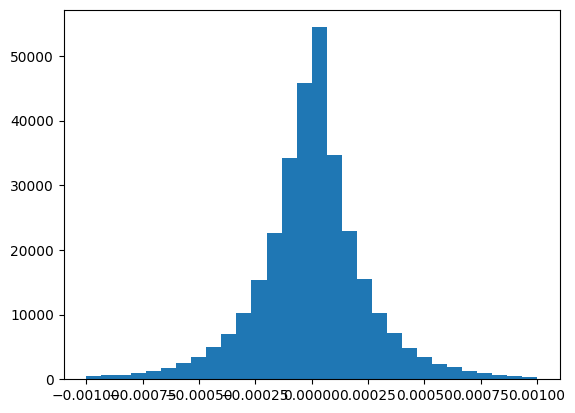

In [8]:
plt.hist(df['return'] , bins=30,range=(-0.001,0.001))

In [9]:
# input_data = df[['close', 'mom','volume']][2:]
input_data = df[['close','volume','mom']][2:]
# targets = df['return'].values
targets = df[['return']][2:].values

In [10]:
input_data

,close,volume,mom
1303830,1.11715,26,1.116840
1303831,1.11732,23,1.117187
1303832,1.11760,10,1.117357
1303833,1.11762,1,1.117513
1303834,1.11763,5,1.117617
...,...,...,...
1620745,1.08773,391,1.087737
1620746,1.08782,382,1.087737
1620747,1.08774,394,1.087763
1620748,1.08781,444,1.087790


In [11]:
targets

array([[ 5.37080965e-05],
       [ 1.52149787e-04],
       [ 2.50536865e-04],
       ...,
       [-7.35469873e-05],
       [ 6.43494728e-05],
       [ 7.35368466e-05]])

In [12]:
T = 10
D = input_data.shape[1]
N = len(input_data) - T
print(D)

3


In [13]:
Ntrain=int(len(input_data)*0.8)
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T - 1])
input_data = scaler.transform(input_data)

In [14]:
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
    X_train[t, :, :] = input_data[t:t+T]
    Y_train[t] = (targets[t+T]>0)

/var/folders/dk/w9782s892tj0nd0v2724j3qr0000gr/T/ipykernel_33670/2205433053.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_train[t] = (targets[t+T]>0)


In [15]:
X_train

array([[[-0.06131757, -1.33045878, -0.06599964],
        [-0.05875085, -1.33575745, -0.06076551],
        [-0.05452332, -1.35871837, -0.05819878],
        [-0.05422135, -1.3746144 , -0.05583335],
        [-0.05407037, -1.3675495 , -0.05427318],
        [-0.05407037, -1.37284817, -0.0541222 ]],

       [[-0.05875085, -1.33575745, -0.06076551],
        [-0.05452332, -1.35871837, -0.05819878],
        [-0.05422135, -1.3746144 , -0.05583335],
        [-0.05407037, -1.3675495 , -0.05427318],
        [-0.05407037, -1.37284817, -0.0541222 ],
        [-0.03685824, -1.3534197 , -0.04833446]],

       [[-0.05452332, -1.35871837, -0.05819878],
        [-0.05422135, -1.3746144 , -0.05583335],
        [-0.05407037, -1.3675495 , -0.05427318],
        [-0.05407037, -1.37284817, -0.0541222 ],
        [-0.03685824, -1.3534197 , -0.04833446],
        [-0.03383857, -1.37284817, -0.04159048]],

       ...,

       [[-0.36932398,  0.27680563, -0.36379136],
        [-0.37264561,  0.35805196, -0.36806925],
 

In [16]:
X_train.shape

(253536, 6, 3)

In [17]:
Y_train

array([1., 1., 1., ..., 1., 0., 1.])

In [18]:
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
    t = u + Ntrain
    X_test[u, :, :] = input_data[t:t+T]
    Y_test[u] = (targets[t+T]>0 )

/var/folders/dk/w9782s892tj0nd0v2724j3qr0000gr/T/ipykernel_33670/229010567.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Y_test[u] = (targets[t+T]>0 )


In [19]:

i = Input(shape=(T, D))
x = LSTM(30, dropout=0.2)(i)
# x = LSTM(50, dropout=0.2)(i)

# x=keras.layers.Dropout(0.3)(x)

#x= Dense(10, activation='relu')(x)
#x=keras.layers.Dropout(0.3)(x)

x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(learning_rate=0.005),
# instead of learning_rate=0.001
  metrics=['accuracy'],
)

In [20]:
#es = EarlyStopping(patience=20, restore_best_weights=True)
#callbacks=[es],
history = model.fit(X_train, Y_train,
          validation_split=0.2,
          batch_size=32,
          epochs=30,
          verbose=1)

Epoch 1/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.5091 - loss: 0.6936 - val_accuracy: 0.4948 - val_loss: 0.6936
Epoch 2/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5050 - val_loss: 0.6934
Epoch 3/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.5050 - val_loss: 0.6937
Epoch 4/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5083 - loss: 0.6930 - val_accuracy: 0.4990 - val_loss: 0.6932
Epoch 5/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.5052 - val_loss: 0.6931
Epoch 6/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5110 - loss: 0.6929 - val_accuracy: 0.4979 - val_loss: 0.6936
Epoch 7/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - accuracy: 0.5104 - loss: 0.6930 - val_accuracy: 0.5052 - val_loss: 0.6932
Epoch 8/30
6339/6339 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.5098 - loss: 0

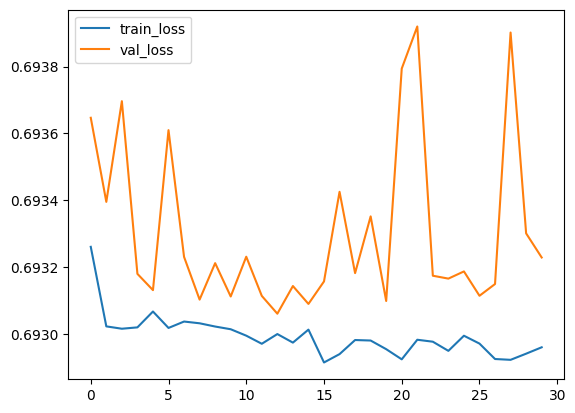

In [21]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

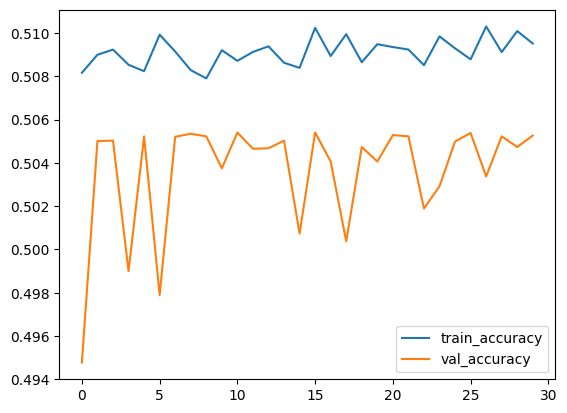

In [22]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [23]:
pred=model.predict(X_test)


1981/1981 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


In [24]:
pred

array([[0.48626044],
       [0.48499113],
       [0.48691443],
       ...,
       [0.48320854],
       [0.48341635],
       [0.48404002]], dtype=float32)

In [25]:
lstm2=model.evaluate(X_test, Y_test)

1981/1981 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.5131 - loss: 0.6926


(array([1.0000e+00, 3.0000e+00, 3.0000e+00, 8.0000e+00, 1.5000e+01,
        1.6000e+01, 2.6000e+01, 3.9000e+01, 6.8000e+01, 7.3000e+01,
        8.7000e+01, 1.1400e+02, 1.5100e+02, 3.4100e+02, 7.1900e+02,
        1.2330e+03, 1.5280e+03, 2.2470e+03, 4.5120e+03, 2.2351e+04,
        1.4401e+04, 8.3860e+03, 4.0940e+03, 1.3410e+03, 8.0100e+02,
        3.9400e+02, 1.6700e+02, 7.7000e+01, 4.9000e+01, 3.5000e+01,
        2.5000e+01, 1.9000e+01, 1.2000e+01, 5.0000e+00, 9.0000e+00,
        5.0000e+00, 9.0000e+00, 2.0000e+00, 0.0000e+00, 4.0000e+00,
        0.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.4284097 , 0.43127707, 0.43414444, 0.4370118 , 0.43987915,
        0.44274652, 0.4456139 , 0.44848126, 0.45134863, 0.454216  ,
        0.45708334, 0.45995072, 0.4628181 , 0.46568546, 0.46855283,
        0.4714202 , 0.47428754, 0.4771549 , 0.48002228, 0.48288965,
        0.48575702, 0.4886244 , 0.49149173, 0.

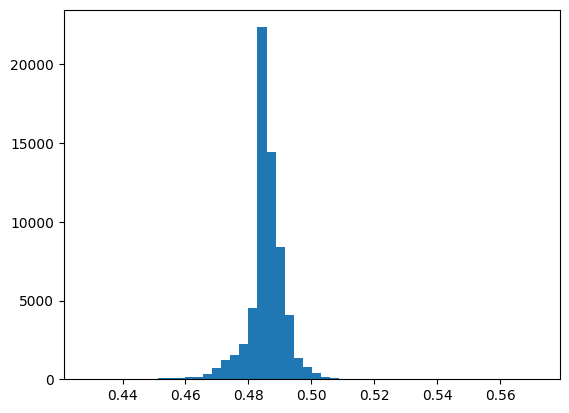

In [28]:
plt.hist(pred, bins=50)


(array([32472.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 30906.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

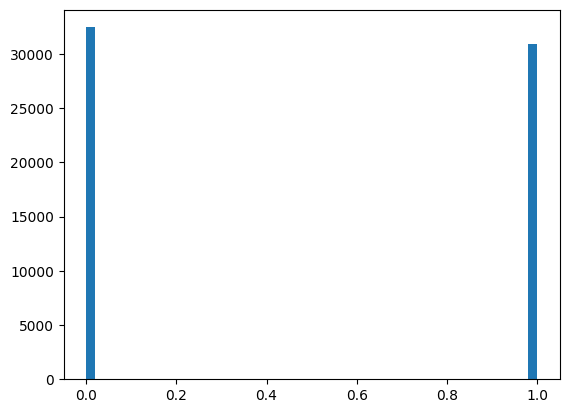

In [29]:
plt.hist(Y_test, bins=50)

In [27]:
model.save("model1.h5")